In [1]:
#imports
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

pd.set_option('display.float_format',lambda x: '%.1f' %x)

In [2]:
# Load the datasets for 2019 data
data2019 = pd.read_csv(r'C:\Users\abandyopadhyay\ALOKPARNA\RCV_SLOTTING\Dataset\Slotting_2019.csv', header=0, encoding = 'unicode_escape')
print("----- Feature Set ----- \n", list(data2019.columns))

data2019 = data2019.fillna(0)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


----- Feature Set ----- 
 ['UniqueId', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'Season_SKU_Introduced', 'Year_SKU_Introduced', 'History_Size_Pct', 'Month', 'Season', 'Year', 'Quarter', 'PlannedUnits', 'PDXPlannedUnits', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume', 'Experiment_Id']


In [3]:
# Function to identify whether a product is new or not and add that as a feature in the dataset
def new_product(data):
  data.loc[(data.Year_SKU_Introduced < 2019) | ((data['Year_SKU_Introduced']).isnull()), 'NewProduct'] = '0' # Existing product
  data.loc[data.Year_SKU_Introduced >= 2019, 'NewProduct'] = '1' # New product
  return (data)

In [4]:
# # Function to Group products by Experiment Id
# def group_by_expId(data):
#   groupedData = data.groupby(['Experiment_Id']).agg({'Demand': 'sum', 'Orders': 'sum', 'Ordered_Units': 'sum', 'Days_Ordered': 'sum', 'Order_Volume': 'sum', 'Avg_Daily_Volume': 'mean'})
#   # Remove the index and flatten the 2019 dataset
#   groupedData.reset_index(inplace=True)
#   print("Grouped dataset (by Experiment Id) shape: ", groupedData.shape)
#   return (groupedData)

In [5]:
# Function to Group products by Experiment Id and Seasons
def group_by_Seasons(data):
  groupedData = data.groupby(['Experiment_Id', 'Season']).agg({'Demand': 'sum', 'Orders': 'sum', 'Ordered_Units': 'sum', 'Days_Ordered': 'sum', 'Order_Volume': 'sum', 'Avg_Daily_Volume': 'mean'})
  # Remove the index and flatten the 2019 dataset
  groupedData.reset_index(inplace=True)
  print("Grouped dataset (by Experiment Id and Seasons) shape: ", groupedData.shape)
  return (groupedData)

In [6]:
# Function to Group products by Experiment Id and Categorical Descriptions
def group_by_Categoricals(data):
  groupedData = data.groupby(['Experiment_Id', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct']).agg({'Demand': 'sum', 'Orders': 'sum','Ordered_Units': 'sum', 'Avg_Daily_Ordered_Units': 'sum', 'Days_Ordered': 'sum', 'Order_Volume': 'sum', 'Avg_Daily_Volume': 'mean'})
  # Remove index and flatten the dataset
  groupedData.reset_index(inplace=True)
  print("Grouped dataset (Experiment Id and Categoricals) shape: ", groupedData.shape)
  return (groupedData)

In [7]:
# Function to Group products by Experiment Id, Seasons and Categorical Descriptions
def group_by_SeasonsAndCategoricals(data):
  groupedData = data.groupby(['Experiment_Id', 'Season', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct']).agg({'Demand': 'sum', 'Orders': 'sum','Ordered_Units': 'sum', 'Avg_Daily_Ordered_Units': 'sum', 'Days_Ordered': 'sum', 'Order_Volume': 'sum', 'Avg_Daily_Volume': 'mean'})
  # Remove index and flatten the dataset
  groupedData.reset_index(inplace=True)
  print("Grouped dataset (Experiment Id, Seasons and Categoricals) shape: ", groupedData.shape)
  return (groupedData)

In [8]:
# Function to select the Top80 selling products
def get_Top80(data):
  # Calculate % Ordered_Units 
  totalOrdUnits = data['Ordered_Units'].sum()
  data['Pct_OrdUnits'] = (data['Ordered_Units']/totalOrdUnits)*100

  # Sort the dataset based on % Ordered_Units 
  data = data.sort_values('Pct_OrdUnits',ascending=False)
  data['Cumsum_Pct_OrdUnits'] = data['Pct_OrdUnits'].cumsum()

  # Find the orders with Top 80 sales (ordered units)
  dataTop80 = data[data.Cumsum_Pct_OrdUnits <= 80]
  
  # Drop the Pct_OrdUnits and Cumsum_Pct_OrdUnits columns
  dataTop80 = dataTop80.drop(['Pct_OrdUnits', 'Cumsum_Pct_OrdUnits'], axis=1)

  print("Dataset shape after retaining the Top80 selling products: ", dataTop80.shape)
  return (dataTop80)

In [9]:
# Function for K-Means clustering
def KMeans_clusterLabels(data, n):# Cluster data using k-means and get the cluster labels
  model = KMeans(n_clusters=n, random_state=1)
  model.fit(data)
  model2019 = model.predict(data)
  # Get cluster labels
  cluster_label = model.labels_
  #Plot the clusters
  plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=model2019, s=50, cmap='viridis')
  centers = model.cluster_centers_
  plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

  return (cluster_label)

In [10]:
# Function for creating Classification Dataset
def create_Classification_Dataset(dataCategorical, dataKmeansLabels):
  # Join the 2 datasets
  data = dataCategorical.merge(dataKmeansLabels, left_on='Experiment_Id', right_on='Experiment_Id')
 
  # Add the new feature 'Suggested_Storage_Type' and the target 'Class' based on the 'Avg_Daily_Volume'
  data.loc[data.Avg_Daily_Volume <= 4216.22, 'Suggested_Storage_Type'] = 'Flat Rack'
  data.loc[data.Avg_Daily_Volume <= 4216.22, 'Class'] = '0'
  data.loc[(data.Avg_Daily_Volume > 4216.22) & (data.Avg_Daily_Volume <= 21081.6), 'Suggested_Storage_Type'] = 'Flow Rack' 
  data.loc[(data.Avg_Daily_Volume > 4216.22) & (data.Avg_Daily_Volume <= 21081.6), 'Class'] = '1' 
  data.loc[data.Avg_Daily_Volume > 21081.6, 'Suggested_Storage_Type'] = 'Big Pack'
  data.loc[data.Avg_Daily_Volume > 21081.6, 'Class'] = '2'
  
  print("Classification dataset shape: ", data.shape)
  return (data)

In [11]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);


In [12]:
# Remove those Data for which there are no Orders
dfOrders2019 = data2019[data2019.Orders != 0]

# Add a new feature 'Demand'
dfOrders2019.loc[dfOrders2019.PlannedUnits != 0, 'Demand'] = dfOrders2019['PlannedUnits']
dfOrders2019.loc[dfOrders2019.PlannedUnits == 0, 'Demand'] = dfOrders2019['PDXPlannedUnits']
#data2019 = data2019.drop(['PlannedUnits', 'PDXPlannedUnits'], axis=1)

# Add a new feature to identify whether a product is New or Existing
dfOrders2019 = new_product(dfOrders2019)

# Group 2019 dataset by Experiment_Id
grouped2019 = group_by_expId(dfOrders2019)

# Group 2019 dataset by Experiment_Id and Seasons
groupedSeasons2019 = group_by_Seasons(dfOrders2019)
groupedSpring2019 = groupedSeasons2019.loc[groupedSeasons2019['Season'] == 0].drop(['Season'], axis=1)
groupedFall2019 = groupedSeasons2019.loc[groupedSeasons2019['Season'] == 1].drop(['Season'], axis=1)
print("Spring2019 dataset shape: ", groupedSpring2019.shape)
print("Fall2019 dataset shape: ", groupedFall2019.shape)

# Group 2019 dataset by Experiment_Id and Categorical Descriptions
groupedCat2019 = group_by_Categoricals(dfOrders2019)

# Group 2019 dataset by Experiment_Id, Seasons and Categoricals
groupedCatSeasons2019 = group_by_SeasonsAndCategoricals(dfOrders2019)
groupedCatSpring2019 = groupedCatSeasons2019.loc[groupedCatSeasons2019['Season'] == 0].drop(['Season'], axis=1)
groupedCatFall2019 = groupedCatSeasons2019.loc[groupedCatSeasons2019['Season'] == 1].drop(['Season'], axis=1)
print("Spring2019 with categorical dataset shape: ", groupedCatSpring2019.shape)
print("Fall2019 with categorical dataset shape: ", groupedCatFall2019.shape)

# Get Top80 most sold products
df2019_Top80 = get_Top80(grouped2019)
dfSpring2019_Top80 = get_Top80(groupedSpring2019)
dfFall2019_Top80 = get_Top80(groupedFall2019)

dfCat2019_Top80 = get_Top80(groupedCat2019)
dfCatSpring2019_Top80 = get_Top80(groupedCatSpring2019)
dfCatFall2019_Top80 = get_Top80(groupedCatFall2019)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Grouped dataset (by Experiment Id) shape:  (22444, 7)
Grouped dataset (by Experiment Id and Seasons) shape:  (39392, 8)
Spring2019 dataset shape:  (20247, 7)
Fall2019 dataset shape:  (19145, 7)
Grouped dataset (Experiment Id and Categoricals) shape:  (22559, 20)
Grouped dataset (Experiment Id, Seasons and Categoricals) shape:  (39596, 21)
Spring2019 with categorical dataset shape:  (20338, 20)
Fall2019 with categorical dataset shape:  (19258, 20)
Dataset shape after retaining the Top80 selling products:  (3126, 7)
Dataset shape after retaining the Top80 selling products:  (2449, 7)
Dataset shape after retaining the Top80 selling products:  (3256, 7)
Dataset shape after retaining the Top80 selling products:  (3133, 20)
Dataset shape after retaining the Top80 selling products:  (2452, 20)
Dataset shape after retaining the Top80 selling products:  (3266, 20)


In [13]:
df2019_Top80.head(25)

,Experiment_Id,Demand,Orders,Ordered_Units,Days_Ordered,Order_Volume,Avg_Daily_Volume
2004,6236,318486.0,15442.0,284667.0,213.0,17546870.0,84547.8
1714,5581,133451.0,29548.0,123091.0,216.0,11816736.0,53964.2
1749,5631,114320.0,200.0,118123.0,109.0,11339808.0,112790.8
2008,6240,132952.0,10150.0,104380.0,210.0,4604198.0,22798.8
2007,6239,121987.0,8327.0,95723.0,214.0,4486534.0,23504.9
10532,23691,89535.0,23002.0,89214.0,215.0,8712634.0,40777.2
1994,6226,117649.0,6425.0,87574.0,200.0,3603666.0,18327.0
1713,5580,89088.0,13416.0,85935.0,215.0,8249760.0,38361.0
2013,6245,77073.0,4610.0,82486.0,212.0,3444611.0,16010.0
10535,23694,79560.0,22846.0,76130.0,214.0,8057595.0,37846.4



----- 2019 Cluster_Label counts -----
1    2776
0     284
2      66
Name: Cluster3_Label, dtype: int64


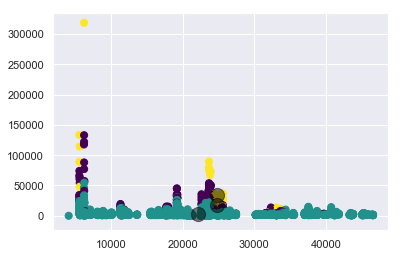

In [14]:
# Cluster 2019 dataset (without categorical descriptions) by K-Means Clustering
df2019_Top80_kmeans = df2019_Top80.copy()

# Add the cluster labels to the dataset
# Number of clusters : 3
cluster3_label = KMeans_clusterLabels(df2019_Top80, 3)
df2019_Top80_kmeans['Cluster3_Label'] = cluster3_label

print("\n----- 2019 Cluster_Label counts -----")
print(df2019_Top80_kmeans['Cluster3_Label'].value_counts())


----- 2019 Cluster_Label counts -----
0    2671
2     346
1      81
3      28
Name: Cluster4_Label, dtype: int64


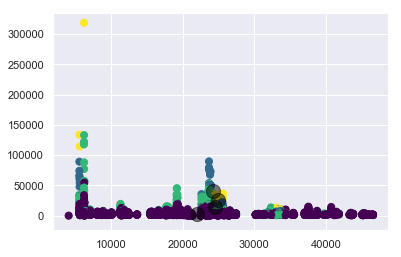

In [15]:
# Number of clusters : 4
cluster4_label = KMeans_clusterLabels(df2019_Top80, 4)
df2019_Top80_kmeans['Cluster4_Label'] = cluster4_label

print("\n----- 2019 Cluster_Label counts -----")
print(df2019_Top80_kmeans['Cluster4_Label'].value_counts())

In [16]:
# Remove the order details and retain only the cluster labels along with the Experiment_Id
df2019_Top80_kmeans_labels = df2019_Top80_kmeans.drop(['Demand', 'Orders', 'Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume'], axis=1)
print("Dataset shape: ", df2019_Top80_kmeans_labels.shape)

# Clustering Accuracy : Calculate Silhouette Coefficient
# Evaluate the 3-cluster model
accuracyCluster3 = silhouette_score(df2019_Top80, cluster3_label)
print("Accuracy of kmeans with n=3: ", accuracyCluster3)
# Evaluate the 4-cluster model
accuracyCluster4 = silhouette_score(df2019_Top80, cluster4_label)
print("Accuracy of kmeans with n=4: ", accuracyCluster4)

Dataset shape:  (3126, 3)
Accuracy of kmeans with n=3:  0.7830683819168089
Accuracy of kmeans with n=4:  0.7457910676549759



----- Spring 2019 Cluster_Label counts -----
1    2135
0     257
2      57
Name: Cluster3_Label, dtype: int64
Dataset shape:  (2449, 2)
Accuracy of kmeans with n=3 on Spring2019:  0.7793446463928267


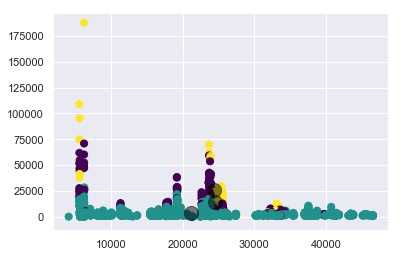

In [17]:
# Cluster Spring 2019 and Fall 2019 datasets (without categorical descriptions) by K-Means Clustering
# Kmeans with n=3 on Spring2019 Data
dfSpring2019_Top80_kmeans = dfSpring2019_Top80.copy()
spring_cluster3_label = KMeans_clusterLabels(dfSpring2019_Top80, 3)
dfSpring2019_Top80_kmeans['Cluster3_Label'] = spring_cluster3_label

print("\n----- Spring 2019 Cluster_Label counts -----")
print(dfSpring2019_Top80_kmeans['Cluster3_Label'].value_counts())

# Remove the order details and retain only the cluster labels along with the Experiment_Id
dfSpring2019_Top80_kmeans_labels = dfSpring2019_Top80_kmeans.drop(['Demand', 'Orders', 'Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume'], axis=1)
print("Dataset shape: ", dfSpring2019_Top80_kmeans_labels.shape)

# Clustering Accuracy : Calculate Silhouette Coefficient
# Evaluate the 3-cluster model for Spring2019
accuracySpring = silhouette_score(dfSpring2019_Top80, spring_cluster3_label)
print("Accuracy of kmeans with n=3 on Spring2019: ", accuracySpring)


----- Fall 2019 Cluster_Label counts -----
0    2860
1     367
2      29
Name: Cluster3_Label, dtype: int64
Dataset shape:  (3256, 2)
Accuracy of kmeans with n=3 on Fall2019:  0.7605109964703124


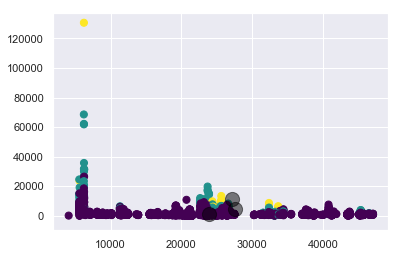

In [18]:
# Kmeans with n=3 on Fall2019 Data
dfFall2019_Top80_kmeans = dfFall2019_Top80.copy()
fall_cluster3_label = KMeans_clusterLabels(dfFall2019_Top80, 3)
dfFall2019_Top80_kmeans['Cluster3_Label'] = fall_cluster3_label

print("\n----- Fall 2019 Cluster_Label counts -----")
print(dfFall2019_Top80_kmeans['Cluster3_Label'].value_counts())

# Remove the order details and retain only the cluster labels along with the Experiment_Id
dfFall2019_Top80_kmeans_labels = dfFall2019_Top80_kmeans.drop(['Demand', 'Orders', 'Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume'], axis=1)
print("Dataset shape: ", dfFall2019_Top80_kmeans_labels.shape)

# Clustering Accuracy : Calculate Silhouette Coefficient
# Evaluate the 3-cluster model for Fall2019
accuracyFall = silhouette_score(dfFall2019_Top80, fall_cluster3_label)
print("Accuracy of kmeans with n=3 on Fall2019: ", accuracyFall)

In [19]:
# Create datasets for Classification (2019, Spring2019 and Fall2019)
df2019 = create_Classification_Dataset(dfCat2019_Top80, df2019_Top80_kmeans_labels)
print("2019 dataset shape: ", df2019.shape)
print("----- Feature Set ----- \n", list(df2019.columns))

dfSpring2019 = create_Classification_Dataset(dfCatSpring2019_Top80, dfSpring2019_Top80_kmeans_labels)
print("Spring 2019 dataset shape: ", dfSpring2019.shape)
print("----- Feature Set ----- \n", list(dfSpring2019.columns))

dfFall2019 = create_Classification_Dataset(dfCatFall2019_Top80, dfFall2019_Top80_kmeans_labels)
print("Fall 2019 dataset shape: ", dfFall2019.shape)
print("----- Feature Set ----- \n", list(dfFall2019.columns))

Classification dataset shape:  (3111, 24)
2019 dataset shape:  (3111, 24)
----- Feature Set ----- 
 ['Experiment_Id', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct', 'Demand', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume', 'Cluster3_Label', 'Cluster4_Label', 'Suggested_Storage_Type', 'Class']
Classification dataset shape:  (2438, 23)
Spring 2019 dataset shape:  (2438, 23)
----- Feature Set ----- 
 ['Experiment_Id', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct', 'Demand', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume', 'Cluster3_Label', 'Suggested_Storage_Type', 'Class']
Classification dataset shape:  (3247, 23)
Fall 2019 dataset shape:  (3247, 23)
----- Feature Set ----

In [20]:
# Corelation matrix
corr = df2019[['Volume', 'NewProduct', 'Demand', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume']].corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,Volume,Demand,Orders,Ordered_Units,Avg_Daily_Ordered_Units,Days_Ordered,Order_Volume,Avg_Daily_Volume
Volume,1,-0.103711,-0.180163,-0.105518,-0.0392481,-0.197453,0.43093,0.478267
Demand,-0.103711,1,0.706794,0.992295,0.778722,0.190878,0.548193,0.160785
Orders,-0.180163,0.706794,1,0.726045,0.464178,0.313459,0.388777,0.0370819
Ordered_Units,-0.105518,0.992295,0.726045,1,0.795392,0.196011,0.56614,0.173647
Avg_Daily_Ordered_Units,-0.0392481,0.778722,0.464178,0.795392,1,-0.0668382,0.48061,0.435447
Days_Ordered,-0.197453,0.190878,0.313459,0.196011,-0.0668382,1,0.0994486,-0.365567
Order_Volume,0.43093,0.548193,0.388777,0.56614,0.48061,0.0994486,1,0.5406
Avg_Daily_Volume,0.478267,0.160785,0.0370819,0.173647,0.435447,-0.365567,0.5406,1


In [21]:
# Create one-vs-rest multinomial logistic regression object
clf = LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg')
FEATURE_SET = ['Volume', 'NewProduct']
TARGET_CLUSTER3 = ['Cluster3_Label']
TARGET_CLUSTER4 = ['Cluster4_Label']
TARGET_CLASS = ['Class']

#2019 DATA
X = df2019[FEATURE_SET] # Training Set
y1 = df2019[TARGET_CLUSTER3] # Target: 3-cluster labels
y2 = df2019[TARGET_CLUSTER4] # Target: 4-cluster labels
y3 = df2019[TARGET_CLASS]    # Target: Class (Dale's classification)

# Train Model and get the Accuracy Score
# Target: 3-cluster labels of 2019
model1 = clf.fit(X, y1)
accuracy1 = model1.score(X, y1)
print("Accuracy of 2019 data with 3-cluster labels: ", accuracy1)

# Train Model and get the Accuracy Score
# Target: 4-cluster labels of 2019
model2 = clf.fit(X, y2)
accuracy2 = model2.score(X, y2)
print("Accuracy of 2019 data with 4-cluster labels: ", accuracy2)

# Target: Class (Dale's classification)
model3 = clf.fit(X, y3)
model3.score(X, y3)
accuracy3 = model3.score(X, y3)
print("Accuracy of 2019 data with class labels: ", accuracy3)

# SPRING2019 DATA
spring_X = dfSpring2019[FEATURE_SET] # Training Set
spring_y1 = dfSpring2019[TARGET_CLUSTER3] # Target: 3-cluster labels
spring_y2 = dfSpring2019[TARGET_CLASS]    # Target: Class (Dale's classification)

# Train Model and get the Accuracy Score
# Target: 3-cluster labels of Spring2019
spring_model1 = clf.fit(spring_X, spring_y1)
spring_accuracy1 = spring_model1.score(spring_X, spring_y1)
print("Accuracy of Spring 2019 data with 3-cluster labels: ", spring_accuracy1)

# Train Model and get the Accuracy Score
# Target: Class (Dale's classification)
# Target: 3-cluster labels of Spring2019
spring_model2 = clf.fit(spring_X, spring_y2)
spring_accuracy2 = spring_model2.score(spring_X, spring_y2)
print("Accuracy of Spring 2019 data with class labels: ", spring_accuracy2)

# FALL2019 DATA
fall_X = dfFall2019[FEATURE_SET] # Training Set
fall_y1 = dfFall2019[TARGET_CLUSTER3] # Target: 3-cluster labels
fall_y2 = dfFall2019[TARGET_CLASS]    # Target: Class (Dale's classification)

# Train Model and get the Accuracy Score
# Target: 3-cluster labels of Fall2019
fall_model1 = clf.fit(fall_X, fall_y1)
fall_accuracy1 = fall_model1.score(fall_X, fall_y1)
print("Accuracy of Fall 2019 data with 3-cluster labels: ", fall_accuracy1)

# Train Model and get the Accuracy Score
# Target: Class (Dale's classification)
fall_model2 = clf.fit(fall_X, fall_y2)
fall_accuracy2 = fall_model2.score(fall_X, fall_y2)
print("Accuracy of Fall 2019 data with class labels: ", fall_accuracy2)


#Nice to have if you have time https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_multinomial.html#sphx-glr-auto-examples-linear-model-plot-logistic-multinomial-py

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of 2019 data with 3-cluster labels:  0.8916747026679525


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of 2019 data with 4-cluster labels:  0.8688524590163934


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of 2019 data with class labels:  0.7004178720668596


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of Spring 2019 data with 3-cluster labels:  0.8798195242001641


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of Spring 2019 data with class labels:  0.7132895816242822


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of Fall 2019 data with 3-cluster labels:  0.8878965198644903


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of Fall 2019 data with class labels:  0.6421311980289498
